In [1]:
import math
import numpy as np 
import cv2 as cv

In [2]:

import torch
import torch.nn as nn

In [ ]:
torch.cuda.is_available()

In [ ]:
gt_mask = torch.ones((2, 4))
gt_mask[0, 3] = 0
gt_mask = gt_mask.unsqueeze(-1)
gt_mask = gt_mask.expand(-1, -1, 8).bool()
print(gt_mask)

In [ ]:
align_metric=torch.tensor([[[10,1,2,1,1,1,1,10],
                            [3,4,5,1,1,1,1,1],
                            [7,8,9,1,1,1,1,1],
                            [1,4,7,1,1,1,1,1]],

                            [[10,1,2,1,1,1,1,10],
                            [0,4,5,1,1,1,1,1],
                            [7,0,0,1,1,9,1,1],
                            [1,4,7,1,1,1,1,1]]],dtype=torch.float32)

topk = torch.topk(align_metric, k=3, dim=-1, largest=True)
print(align_metric)
print(topk[0])
print(topk[1])

In [ ]:
topk_mask = torch.ones((2, 4, 1))
topk_mask[0, 3] = 0
topk_mask = topk_mask.expand(-1, -1, 3).bool()
print(topk_mask)

topk_idxs = topk[1]
topk_idxs.masked_fill_(~topk_mask, 0)
print(topk_idxs)



In [ ]:
count_tensor = torch.zeros(align_metric.shape, dtype=torch.int8, device=topk_idxs.device)
ones = torch.ones_like(topk_idxs[:, :, :1], dtype=torch.int8, device=topk_idxs.device)
for k in range(3):
    count_tensor.scatter_add_(-1, topk_idxs[:, :, k:k + 1], ones)
count_tensor.masked_fill_(count_tensor > 1, 0)
print(count_tensor)

In [ ]:
mask_pos = gt_mask * count_tensor
mask_pos

In [ ]:
fg_mask = mask_pos.sum(-2)
fg_mask

In [ ]:
mask_multi_gts = (fg_mask.unsqueeze(1) > 1).expand(-1, 4, -1)
mask_multi_gts

In [ ]:
overlaps = torch.rand((2, 4, 8))
overlaps

In [ ]:
max_overlaps_idx = overlaps.argmax(1)  # (b, h*w)
max_overlaps_idx

In [ ]:
is_max_overlaps = torch.zeros(mask_pos.shape, dtype=mask_pos.dtype, device=mask_pos.device)
is_max_overlaps

In [ ]:
max_overlaps_idx.unsqueeze(1)

In [ ]:
is_max_overlaps.scatter_(1, max_overlaps_idx.unsqueeze(1), 1)

In [ ]:
mask_multi_gts

In [ ]:
mask_pos

In [ ]:
mask_pos = torch.where(mask_multi_gts, is_max_overlaps, mask_pos).float()
mask_pos

In [ ]:
fg_mask = mask_pos.sum(-2)
fg_mask

In [ ]:
target_gt_idx = mask_pos.argmax(-2)
target_gt_idx

In [ ]:
gt_labels = torch.randint(0, 16, (2, 4, 1))
gt_labels[0, 3, 0] = 0
gt_labels

In [ ]:
# Assigned target labels, (b, 1)
batch_ind = torch.arange(end=2, dtype=torch.int64, device=gt_labels.device)[..., None]
batch_ind

In [ ]:
target_gt_idx = target_gt_idx + batch_ind * 4
target_gt_idx

In [ ]:
gt_labels.long().flatten()

In [ ]:
target_labels = gt_labels.long().flatten()[target_gt_idx]
target_labels

In [ ]:
gt_bboxes = torch.randint(0, 320, (2, 4, 4))
gt_bboxes

In [ ]:
target_bboxes = gt_bboxes.view(-1, 4)[target_gt_idx]
target_bboxes

In [ ]:
target_labels.clamp_(0)
target_labels

In [ ]:
# 10x faster than F.one_hot()
target_scores = torch.zeros((target_labels.shape[0], target_labels.shape[1], 16),
                            dtype=torch.int64,
                            device=target_labels.device)  # (b, h*w, 80)

target_scores

In [ ]:
target_scores.scatter_(2, target_labels.unsqueeze(-1), 1)
target_scores

In [ ]:
fg_scores_mask = fg_mask[:, :, None].repeat(1, 1, 16)
fg_scores_mask

In [ ]:
target_scores = torch.where(fg_scores_mask > 0, target_scores, 0)
target_scores

In [ ]:
target_scores.size()

In [ ]:
# Normalize
align_metric *= mask_pos
align_metric

In [ ]:
pos_align_metrics = align_metric.amax(axis=-1, keepdim=True)
pos_align_metrics

In [ ]:
overlaps * mask_pos

In [ ]:
pos_overlaps = (overlaps * mask_pos).amax(axis=-1, keepdim=True)
pos_overlaps

In [ ]:
align_metric * pos_overlaps / (pos_align_metrics + 1e-9)

In [ ]:
norm_align_metric = (align_metric * pos_overlaps / (pos_align_metrics + 1e-9)).amax(-2).unsqueeze(-1)
norm_align_metric

In [ ]:

target_scores = target_scores * norm_align_metric

In [ ]:
target_scores[0]

In [ ]:
target_bboxes.size(), target_scores.size(), fg_mask.size()

In [ ]:
batch_size = 2
feats = [torch.rand((batch_size, 256, 80, 80)), 
         torch.rand((batch_size, 512, 40, 40)), 
         torch.rand((batch_size, 512, 20, 20))]

s = 640
strides = torch.tensor([s / x.shape[-2] for x in feats])
strides

In [ ]:


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Pad to 'same' shape outputs."""
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class Conv(nn.Module):
    """Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)."""
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        """Initialize Conv layer with given arguments including activation."""
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        """Apply convolution, batch normalization and activation to input tensor."""
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        """Perform transposed convolution of 2D data."""
        return self.act(self.conv(x))
    

ch = (256, 512, 512)

reg_max = 16 
nc = 16

c2, c3 = max((16, ch[0] // 4, reg_max * 4)), max(ch[0], min(nc, 100))

print(c2, c3)

cv2 = nn.ModuleList(
    nn.Sequential(
        Conv(x, c2, 3), 
        Conv(c2, c2, 3),
        nn.Conv2d(c2, 4 * reg_max, 1)) for x in ch)

cv3 = nn.ModuleList(
    nn.Sequential(
        Conv(x, c3, 3), 
        Conv(c3, c3, 3),
        nn.Conv2d(c3, nc, 1)) for x in ch)


for i in range(len(ch)):
    print(cv2[i](feats[i]).size(),cv3[i](feats[i]).size())
    print(torch.cat((cv2[i](feats[i]), cv3[i](feats[i])), 1).size())
    feats[i] = torch.cat((cv2[i](feats[i]), cv3[i](feats[i])), 1)



In [ ]:

no = nc + reg_max * 4 
no

In [ ]:
pred_distri, pred_scores = torch.cat([xi.view(feats[0].shape[0], no, -1) for xi in feats], 2).split((reg_max * 4, nc), 1)
pred_distri.size(), pred_scores.size()

In [ ]:
pred_distri = pred_distri.permute(0, 2, 1).contiguous()
pred_scores = pred_scores.permute(0, 2, 1).contiguous()
pred_distri.size(), pred_scores.size()

In [ ]:
pred_distri = torch.rand((2, 8, 16 * 4))
pred_scores = torch.rand((2, 8, 16))
pred_distri.size(), pred_scores.size()

In [ ]:
bce = nn.BCEWithLogitsLoss(reduction='none')
print(bce(pred_scores, target_scores).sum())
print(-(target_scores * pred_scores.sigmoid().log() + (1 - target_scores) * (1 - pred_scores.sigmoid()).log()).sum())

In [ ]:
def make_anchors(feats, strides, grid_cell_offset=0.5):
    """Generate anchors from features."""
    anchor_points, stride_tensor = [], []
    assert feats is not None
    dtype, device = feats[0].dtype, feats[0].device
    for i, stride in enumerate(strides):
        _, _, h, w = feats[i].shape
        sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
        sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
        sy, sx = torch.meshgrid(sy, sx, indexing='ij') 
        anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
    return torch.cat(anchor_points), torch.cat(stride_tensor)

anchor_points, stride_tensor = make_anchors(feats, strides, 0.5)

print(anchor_points.size())
print(stride_tensor.size())

anchor_points = torch.rand((8, 2))
stride_tensor = torch.randint(8, 32, (8, 1)).float()

print(anchor_points.size())
print(stride_tensor.size())

def bbox2dist(anchor_points, bbox, reg_max):
    """Transform bbox(xyxy) to dist(ltrb)."""
    x1y1, x2y2 = bbox.chunk(2, -1)
    return torch.cat((anchor_points - x1y1, x2y2 - anchor_points), -1).clamp_(0, reg_max - 0.01)



In [ ]:
target_bboxes[0, 0]

In [ ]:
stride_tensor[0]

In [ ]:
anchor_points[0]

In [ ]:
target_bboxes = target_bboxes.float()
target_bboxes /= stride_tensor
target_bboxes[0, 0]

In [ ]:
target_ltrb = bbox2dist(anchor_points, target_bboxes, 16 - 1)

target_ltrb[0, 0]

In [ ]:
pred_distri.size(), target_ltrb.size()

In [ ]:
pred_distri[fg_mask.bool()].size(), target_ltrb[fg_mask.bool()].size()

In [ ]:
import torch.nn.functional as F

In [ ]:
pred_distri[fg_mask.bool()].view(-1, 15 + 1).size()

In [ ]:
target_ltrb[fg_mask.bool()].long()[0,:]

In [ ]:
(target_ltrb[fg_mask.bool()].long() + 1)[0,:]

In [ ]:
((target_ltrb[fg_mask.bool()].long() + 1) - target_ltrb[fg_mask.bool()])[0,:]

In [ ]:
tl = target_ltrb[fg_mask.bool()].long()  # target left
tr = tl + 1  # target right
wl = tr - target_ltrb[fg_mask.bool()]  # weight left
wr = 1 - wl  # weight right

In [ ]:
target_ltrb[fg_mask.bool()][0, :]

In [ ]:
tl[0, :], wl[0, :]

In [ ]:
tr[0, :], wr[0, :]

In [ ]:
pred_distri[fg_mask.bool()].view(-1, 15 + 1).size()


In [ ]:
tl.view(-1)[15], F.one_hot(tl.view(-1), num_classes=16)[15]

In [ ]:
(-(pred_distri[fg_mask.bool()].view(-1, 15 + 1).softmax(-1).log() * F.one_hot(tl.view(-1), num_classes=16)).sum(-1).view(tl.shape) * wl + \
(-(pred_distri[fg_mask.bool()].view(-1, 15 + 1).softmax(-1).log() * F.one_hot(tr.view(-1), num_classes=16)).sum(-1)).view(tl.shape) * wr).mean(-1, keepdim=True)

In [ ]:
(F.cross_entropy(pred_distri[fg_mask.bool()].view(-1, 15 + 1), tl.view(-1), reduction='none').view(tl.shape) * wl +
F.cross_entropy(pred_distri[fg_mask.bool()].view(-1, 15 + 1), tr.view(-1), reduction='none').view(tl.shape) * wr).mean(-1, keepdim=True)

In [ ]:
def dist2bbox(distance, anchor_points, xywh=True, dim=-1):
    """Transform distance(ltrb) to box(xywh or xyxy)."""
    lt, rb = distance.chunk(2, dim)
    x1y1 = anchor_points - lt
    x2y2 = anchor_points + rb
    if xywh:
        c_xy = (x1y1 + x2y2) / 2
        wh = x2y2 - x1y1
        return torch.cat((c_xy, wh), dim)  # xywh bbox
    return torch.cat((x1y1, x2y2), dim)  # xyxy bbox

def bbox_decode(anchor_points, pred_dist):
    """Decode predicted object bounding box coordinates from anchor points and distribution."""

    b, a, c = pred_dist.shape  # batch, anchors, channels
    pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul()
  
    return dist2bbox(pred_dist, anchor_points, xywh=False)




In [ ]:
proj = torch.arange(16, dtype=torch.float)
proj

In [ ]:
b, a, c = pred_distri.shape
pred_distri.view(b, a, 4, c // 4).softmax(3).matmul(proj)[0, 0, 0]

In [ ]:
(pred_distri.view(b, a, 4, c // 4).softmax(3)[0, 0, 0, :] * proj).sum()

In [ ]:
b, a, c = pred_distri.shape
pred_dist = pred_distri.view(b, a, 4, c // 4).softmax(3).matmul(proj)

pd_bboxes = dist2bbox(pred_dist, anchor_points, xywh=False)
pd_bboxes.size()

In [ ]:
pd_bboxes[0, 0]

In [ ]:

def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):

    # Get the coordinates of bounding boxes
    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp_(0) * \
            (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp_(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    if CIoU or DIoU or GIoU:
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU 
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2
            if CIoU: 
                v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
            return iou - rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        return iou - (c_area - union) / c_area 
    return iou  # IoU



In [ ]:

target_scores_sum = max(target_scores.sum(), 1)

weight = target_scores.sum(-1)[fg_mask.bool()].unsqueeze(-1)
iou = bbox_iou(pd_bboxes[fg_mask.bool()], target_bboxes[fg_mask.bool()], xywh=False, CIoU=True)
loss_iou = ((1.0 - iou) * weight).sum() / target_scores_sum
loss_iou

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8n.yaml')
model.train()

In [ ]:
model.val()

In [ ]:

class ShuffleChannel(nn.Module):

    def __init__(self, g) -> None:
        super().__init__()

        self.g = g

    def forward(self, x):
        b, c, h, w = x.size()

        x = x.view()
        x = torch.transpose()
        x = x.view()

        return x

class ShuffleConv(nn.Module):


    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1) -> None:
        super().__init__()

        self.GConv1 = nn.Sequential(
            nn.Conv2d(),
            nn.BatchNorm2d(),
            nn.SiLU(),
        )

        self.DWConv1 = nn.Sequential(
            nn.Conv2d(),
            nn.BatchNorm2d(),
        )

        self.GConv2 = nn.Sequential(
            nn.Conv2d(),
            nn.BatchNorm2d(),
        )

        self.shorcut = nn.Sequential(
            nn.AvgPool2d()
        )

        self.shuffleChannel = ShuffleChannel(g)

    def forward(self, x):
        y = self.GConv1(x)
        y = self.shuffleChannel(y)
        y = self.DWConv1(y)
        y = self.GConv2(y)
        
        short = self.shorcut(x)
        torch.cat([y, short], dim=1)

        return y
        

In [ ]:
class DFL(nn.Module):

    def __init__(self, c1=16):

        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        b, c, a = x.shape
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)
    
class Detect(nn.Module):
    """YOLOv8 Detect head for detection models."""
    dynamic = False  # force grid reconstruction
    export = False  # export mode
    shape = None
    anchors = torch.empty(0)  # init
    strides = torch.empty(0)  # init

    def __init__(self, nc=80, ch=()):  # detection layer
        super().__init__()
        self.nc = nc  # number of classes
        self.nl = len(ch)  # number of detection layers
        self.reg_max = 16  # DFL channels (ch[0] // 16 to scale 4/8/12/16/20 for n/s/m/l/x)
        self.no = nc + self.reg_max * 4  # number of outputs per anchor
        self.stride = torch.zeros(self.nl)  # strides computed during build
        c2, c3 = max((16, ch[0] // 4, self.reg_max * 4)), max(ch[0], self.nc)  # channels
        self.cv2 = nn.ModuleList(
            nn.Sequential(Conv(x, c2, 3), Conv(c2, c2, 3), nn.Conv2d(c2, 4 * self.reg_max, 1)) for x in ch)
        self.cv3 = nn.ModuleList(nn.Sequential(Conv(x, c3, 3), Conv(c3, c3, 3), nn.Conv2d(c3, self.nc, 1)) for x in ch)
        self.dfl = DFL(self.reg_max) if self.reg_max > 1 else nn.Identity()

    def forward(self, x):
        """Concatenates and returns predicted bounding boxes and class probabilities."""
        shape = x[0].shape  # BCHW
        for i in range(self.nl):
            x[i] = torch.cat((self.cv2[i](x[i]), self.cv3[i](x[i])), 1)
        if self.training:
            return x
        elif self.dynamic or self.shape != shape:
            self.anchors, self.strides = (x.transpose(0, 1) for x in make_anchors(x, self.stride, 0.5))
            self.shape = shape

        x_cat = torch.cat([xi.view(shape[0], self.no, -1) for xi in x], 2)
        if self.export and self.format in ('saved_model', 'pb', 'tflite', 'edgetpu', 'tfjs'):  # avoid TF FlexSplitV ops
            box = x_cat[:, :self.reg_max * 4]
            cls = x_cat[:, self.reg_max * 4:]
        else:
            box, cls = x_cat.split((self.reg_max * 4, self.nc), 1)
        dbox = dist2bbox(self.dfl(box), self.anchors.unsqueeze(0), xywh=True, dim=1) * self.strides
        y = torch.cat((dbox, cls.sigmoid()), 1)
        return y if self.export else (y, x)

    def bias_init(self):
        """Initialize Detect() biases, WARNING: requires stride availability."""
        m = self  # self.model[-1]  # Detect() module
        # cf = torch.bincount(torch.tensor(np.concatenate(dataset.labels, 0)[:, 0]).long(), minlength=nc) + 1
        # ncf = math.log(0.6 / (m.nc - 0.999999)) if cf is None else torch.log(cf / cf.sum())  # nominal class frequency
        for a, b, s in zip(m.cv2, m.cv3, m.stride):  # from
            a[-1].bias.data[:] = 1.0  # box
            b[-1].bias.data[:m.nc] = math.log(5 / m.nc / (640 / s) ** 2)  # cls (.01 objects, 80 classes, 640 img)

In [ ]:
class SPPF(nn.Module):
    """Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher."""

    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        """Forward pass through Ghost Convolution block."""
        x = self.cv1(x)
        y1 = self.m(x)
        y2 = self.m(y1)
        return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))

In [ ]:
class Bottleneck(nn.Module):
    """Standard bottleneck."""

    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5):  # ch_in, ch_out, shortcut, groups, kernels, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        """'forward()' applies the YOLOv5 FPN to input data."""
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

class C2f(nn.Module):
    """CSP Bottleneck with 2 convolutions."""

    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv((2 + n) * self.c, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.ModuleList(Bottleneck(self.c, self.c, shortcut, g, k=((3, 3), (3, 3)), e=1.0) for _ in range(n))

    def forward(self, x):
        """Forward pass through C2f layer."""
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))

    def forward_split(self, x):
        """Forward pass using split() instead of chunk()."""
        y = list(self.cv1(x).split((self.c, self.c), 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))

In [7]:
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8n.yaml')
model.train()

In [3]:
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt
import cv2 as cv
import torch

In [ ]:

class Metric():

    def __init__(self) -> None:
        self.p = []  # (nc, )
        self.r = []  # (nc, )
        self.f1 = []  # (nc, )
        self.all_ap = []  # (nc, 10)
        self.ap_class_index = []  # (nc, )
        self.nc = 0

    @property
    def ap50(self):
        return self.all_ap[:, 0] if len(self.all_ap) else []

    @property
    def ap(self):
        return self.all_ap.mean(1) if len(self.all_ap) else []

    @property
    def mp(self):
        return self.p.mean() if len(self.p) else 0.0

    @property
    def mr(self):
        return self.r.mean() if len(self.r) else 0.0

    @property
    def map50(self):
        return self.all_ap[:, 0].mean() if len(self.all_ap) else 0.0

    @property
    def map75(self):
        return self.all_ap[:, 5].mean() if len(self.all_ap) else 0.0

    @property
    def map(self):
        return self.all_ap.mean() if len(self.all_ap) else 0.0

    def mean_results(self):
        return [self.mp, self.mr, self.map50, self.map]

    def class_result(self, i):
        return self.p[i], self.r[i], self.ap50[i], self.ap[i]

    @property
    def maps(self):
        maps = np.zeros(self.nc) + self.map
        for i, c in enumerate(self.ap_class_index):
            maps[c] = self.ap[i]
        return maps

    def fitness(self):
        w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
        return (np.array(self.mean_results()) * w).sum()

    def update(self, results):
        self.p, self.r, self.f1, self.all_ap, self.ap_class_index = results


class DetMetrics():
    
    def __init__(self, save_dir=Path('.'), plot=False, on_plot=None, names=()) -> None:
        self.save_dir = save_dir
        self.plot = plot
        self.on_plot = on_plot
        self.names = names
        self.box = Metric()
        self.speed = {'preprocess': 0.0, 'inference': 0.0, 'loss': 0.0, 'postprocess': 0.0}

    def process(self, tp, conf, pred_cls, target_cls):
        results = ap_per_class(tp,
                               conf,
                               pred_cls,
                               target_cls,
                               plot=self.plot,
                               save_dir=self.save_dir,
                               names=self.names,
                               on_plot=self.on_plot)[2:]
        self.box.nc = len(self.names)
        self.box.update(results)

    @property
    def keys(self):
        return ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

    def mean_results(self):
        return self.box.mean_results()

    def class_result(self, i):
        return self.box.class_result(i)

    @property
    def maps(self):
        return self.box.maps

    @property
    def fitness(self):
        return self.box.fitness()

    @property
    def ap_class_index(self):
        return self.box.ap_class_index

    @property
    def results_dict(self):
        return dict(zip(self.keys + ['fitness'], self.mean_results() + [self.fitness]))


In [6]:
def xywh2xyxy(x):

    assert x.shape[-1] == 4, f'input shape last dimension expected 4 but input shape is {x.shape}'
    y = torch.empty_like(x) if isinstance(x, torch.Tensor) else np.empty_like(x)  # faster than clone/copy
    dw = x[..., 2] / 2  # half-width
    dh = x[..., 3] / 2  # half-height
    y[..., 0] = x[..., 0] - dw  # top left x
    y[..., 1] = x[..., 1] - dh  # top left y
    y[..., 2] = x[..., 0] + dw  # bottom right x
    y[..., 3] = x[..., 1] + dh  # bottom right y
    return y


def box_iou(box1, box2, eps=1e-7):

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95

def match_predictions(pred_classes, true_classes, iou, use_scipy=False):
    """
    Matches predictions to ground truth objects (pred_classes, true_classes) using IoU.

    Args:
        pred_classes (torch.Tensor): Predicted class indices of shape(N,).
        true_classes (torch.Tensor): Target class indices of shape(M,).
        iou (torch.Tensor): An NxM tensor containing the pairwise IoU values for predictions and ground of truth
        use_scipy (bool): Whether to use scipy for matching (more precise).

    Returns:
        (torch.Tensor): Correct tensor of shape(N,10) for 10 IoU thresholds.
    """
    # Dx10 matrix, where D - detections, 10 - IoU thresholds
    correct = np.zeros((pred_classes.shape[0], iouv.shape[0])).astype(bool)
    # LxD matrix where L - labels (rows), D - detections (columns)
    correct_class = true_classes[:, None] == pred_classes
    iou = iou * correct_class  # zero out the wrong classes
    iou = iou.cpu().numpy()
    for i, threshold in enumerate(iouv.cpu().tolist()):
        if use_scipy:
            # WARNING: known issue that reduces mAP in https://github.com/ultralytics/ultralytics/pull/4708
            import scipy  # scope import to avoid importing for all commands
            cost_matrix = iou * (iou >= threshold)
            if cost_matrix.any():
                labels_idx, detections_idx = scipy.optimize.linear_sum_assignment(cost_matrix, maximize=True)
                valid = cost_matrix[labels_idx, detections_idx] > 0
                if valid.any():
                    correct[detections_idx[valid], i] = True
        else:
            matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
            matches = np.array(matches).T
            if matches.shape[0]:
                if matches.shape[0] > 1:
                    matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                    # matches = matches[matches[:, 2].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
                correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=pred_classes.device)


In [7]:
batch_size = 3

preds = torch.randint(0, 320, (batch_size, 200, 4))
preds[..., 0] = preds[..., 0] + preds[..., 2] / 2
preds[..., 1] = preds[..., 1] + preds[..., 3] / 2
preds = xywh2xyxy(preds)
# preds = preds.float()

preds = torch.cat((preds, torch.rand((batch_size, 200, 1))), -1)

preds = torch.cat((preds, torch.randint(0, 2, (batch_size, 200, 1))), -1)  # native-space labels


torch.Size([200, 10])
torch.Size([200, 10])
torch.Size([200, 10])


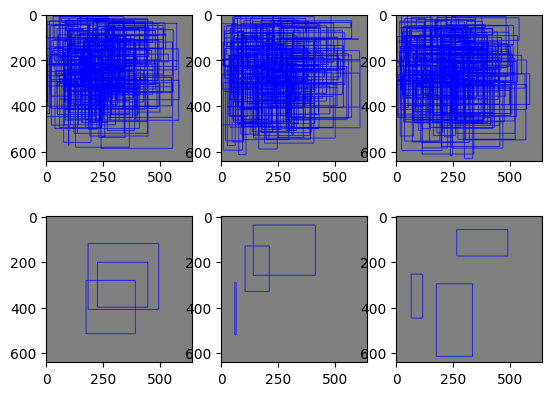

In [8]:


plt.figure()


stats = []

for si, pred in enumerate(preds):


    image = np.full_like(np.empty((640, 640, 3), np.uint8), 128)
    for box in pred:
        box = box.int()
        cv.rectangle(image, (box[0].item(), box[1].item()), (box[2].item(), box[3].item()), (0, 0, 255), 2)
    plt.subplot(2, batch_size, si + 1)
    plt.imshow(image)


    cls = torch.randint(0, 2, (3, 1))
    bbox = torch.randint(0, 320, (3, 4))
    bbox[..., 0] = bbox[..., 0] + bbox[..., 2] / 2
    bbox[..., 1] = bbox[..., 1] + bbox[..., 3] / 2
    tbox = xywh2xyxy(bbox)


    image = np.full_like(np.empty((640, 640, 3), np.uint8), 128)
    for box in tbox:
        cv.rectangle(image, (box[0].item(), box[1].item()), (box[2].item(), box[3].item()), (0, 0, 255), 2)
    plt.subplot(2, batch_size, si + batch_size + 1)
    plt.imshow(image)


    detections = pred.clone()
    labels = torch.cat((cls, tbox), 1)  # native-space labels

    iou = box_iou(labels[:, 1:], detections[:, :4])


    correct_bboxes = match_predictions(detections[:, 5], labels[:, 0], iou)

    print(correct_bboxes.shape)


    stats.append((correct_bboxes, pred[:, 4], pred[:, 5], cls.squeeze(-1)))


In [9]:
pred_classes = detections[:, 5]
true_classes = labels[:, 0]


iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95

# Dx10 matrix, where D - detections, 10 - IoU thresholds
correct = np.zeros((pred_classes.shape[0], iouv.shape[0])).astype(bool)
# LxD matrix where L - labels (rows), D - detections (columns)
correct_class = true_classes[:, None] == pred_classes
iou = iou * correct_class  # zero out the wrong classes
iou = iou.cpu().numpy()

# print(iou)

for i, threshold in enumerate(iouv.cpu().tolist()):
    matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
    matches = np.array(matches).T
    
    if matches.shape[0]:
        print("=" * 10)
        print(matches)
        # print(matches.shape)
        if matches.shape[0] > 1:

            print(iou[matches[:, 0], matches[:, 1]])
            # print(iou[matches[:, 0], matches[:, 1]].argsort())
            print(iou[matches[:, 0], matches[:, 1]].argsort()[::-1])

            matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]

            print(matches)
            # print(np.unique(matches[:, 1], return_index=True))
            print("-" * 10)
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]

            print(matches)
            # print(np.unique(matches[:, 0], return_index=True))
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]

            print(matches)
            print(i)

        correct[matches[:, 1].astype(int), i] = True
        # print(iou)
        print(correct[:, i]) 

In [21]:
stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]

In [ ]:
def compute_ap(recall, precision):

    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = 'interp'  # methods: 'continuous', 'interp'
    if method == 'interp':
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x-axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec

def smooth(y, f=0.05):
    """Box filter of fraction f."""
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = np.ones(nf // 2)  # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode='valid')  # y-smoothed

    
def ap_per_class(tp, conf, pred_cls, target_cls, plot=False, on_plot=None, 
                 save_dir=Path(), names=(), eps=1e-16, prefix=''):

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes, nt = np.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    px, py = np.linspace(0, 1, 1000), []  # for plotting
    ap, p, r = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = nt[ci]  # number of labels
        n_p = i.sum()  # number of predictions
        if n_p == 0 or n_l == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # Recall
        recall = tpc / (n_l + eps)  # recall curve
        r[ci] = np.interp(-px, -conf[i], recall[:, 0], left=0)  # negative x, xp because xp decreases

        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        p[ci] = np.interp(-px, -conf[i], precision[:, 0], left=1)  # p at pr_score

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
            if plot and j == 0:
                py.append(np.interp(px, mrec, mpre))  # precision at mAP@0.5

    # Compute F1 (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + eps)
    names = [v for k, v in names.items() if k in unique_classes]  # list: only classes that have data
    names = dict(enumerate(names))  # to dict
    
    # if plot:
    #     plot_pr_curve(px, py, ap, save_dir / f'{prefix}PR_curve.png', names, on_plot=on_plot)
    #     plot_mc_curve(px, f1, save_dir / f'{prefix}F1_curve.png', names, ylabel='F1', on_plot=on_plot)
    #     plot_mc_curve(px, p, save_dir / f'{prefix}P_curve.png', names, ylabel='Precision', on_plot=on_plot)
    #     plot_mc_curve(px, r, save_dir / f'{prefix}R_curve.png', names, ylabel='Recall', on_plot=on_plot)

    i = smooth(f1.mean(0), 0.1).argmax()  # max F1 index
    p, r, f1 = p[:, i], r[:, i], f1[:, i]
    tp = (r * nt).round()  # true positives
    fp = (tp / (p + eps) - tp).round()  # false positives
    return tp, fp, p, r, f1, ap, unique_classes.astype(int)


In [ ]:
def clip_boxes(boxes, shape):


    if isinstance(boxes, torch.Tensor):  # faster individually (WARNING: inplace .clamp_() Apple MPS bug)
        boxes[..., 0] = boxes[..., 0].clamp(0, shape[1])  # x1
        boxes[..., 1] = boxes[..., 1].clamp(0, shape[0])  # y1
        boxes[..., 2] = boxes[..., 2].clamp(0, shape[1])  # x2
        boxes[..., 3] = boxes[..., 3].clamp(0, shape[0])  # y2
    else:  # np.array (faster grouped)
        boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
        boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2
    return boxes

def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None, padding=True):

    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = round((img1_shape[1] - img0_shape[1] * gain) / 2 - 0.1), round(
            (img1_shape[0] - img0_shape[0] * gain) / 2 - 0.1)  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    if padding:
        boxes[..., [0, 2]] -= pad[0]  # x padding
        boxes[..., [1, 3]] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    return clip_boxes(boxes, img0_shape)